# Intro to Market Basket Analysis

### Valerian FOUREL


We will here start the study of our Market Basket Analysis, with the handling of our data. The project to determine how does seasonality affect the Groceries habits of the customers of a particular store.

In [1]:
import numpy as np # we must import our packages for data pre-processing
import pandas as pd # we bring pandas which will be used extensively
from mlxtend.preprocessing import TransactionEncoder # we use the packages for the apriori algorithm
from mlxtend.frequent_patterns import apriori, association_rules # we bring in the association rule
import matplotlib.pyplot as plt
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Questions to answer:
- What does TransactionEncoder do? 
- How does TransactionEconder work?
- What is the apriori Algorithm?
- What are association Rules?

In [2]:
data_basket = pd.read_csv("basket.csv") # bring the data
data = pd.read_csv("GroceriesData.csv") # we add our data into a frame work
data = pd.DataFrame(data) # bring the data in a dataFrame

We must first create the Time Frame, we will study, we will first get it by season. We will infer whether, there are difference in results given the 4 different periods that we consider.
We can then compare the application of the apriori algorithm on all seasons.

# Part 1: Exploring the Data

The first part of the project is to explore the data, in order to obtain, 4 preprocess sets divided by seasonality on which it will be possible to use the Transaction Encoder.

In [3]:
seasons = 4 #Global variable


In [4]:
def seasonEncoding():
    seasons = [month%12 // 3 + 1 for month in range(1, 13)] # we get the number seasonality
    # by number first
    seasonResult = []
    for season in seasons:
        if season ==1:
            seasonResult.append("Winter") # we then append the season to a list matching the
            # index
        elif season ==2:
            seasonResult.append("Spring")
        elif season ==3:
            seasonResult.append("Summer")
        else:
            seasonResult.append("Fall")
    month_to_season = dict(zip(range(1,13), seasonResult)) # we get the dictionary from the
    # month number to the season
    return month_to_season
    

In [5]:
month_to_season = seasonEncoding()
month_to_season # we see the dictionary encoding the Season

{1: 'Winter',
 2: 'Winter',
 3: 'Spring',
 4: 'Spring',
 5: 'Spring',
 6: 'Summer',
 7: 'Summer',
 8: 'Summer',
 9: 'Fall',
 10: 'Fall',
 11: 'Fall',
 12: 'Winter'}

In [6]:
data.head() # this is the "raw" data

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,2552,2015-05-01,whole milk,2015,5,1,4
2,2300,2015-09-19,pip fruit,2015,9,19,5
3,1187,2015-12-12,other vegetables,2015,12,12,5
4,3037,2015-01-02,whole milk,2015,1,2,4


In [7]:
print(data['month'][0]) # the 7th month is July
month_to_season.get(data['month'][0]) #July is a summer month

7


'Summer'

In [8]:
data['season'] = data['month'].apply(lambda month: month_to_season.get(month))
# WE add here the season to our Data frame, so we can then separate the transaction

In [9]:
data.head() # the season is present

,Member_number,Date,itemDescription,year,month,day,day_of_week,season
0,1808,2015-07-21,tropical fruit,2015,7,21,1,Summer
1,2552,2015-05-01,whole milk,2015,5,1,4,Spring
2,2300,2015-09-19,pip fruit,2015,9,19,5,Fall
3,1187,2015-12-12,other vegetables,2015,12,12,5,Winter
4,3037,2015-01-02,whole milk,2015,1,2,4,Winter


In [10]:
g = data.groupby(by='season') # we group by season 

In [11]:
data = data.drop(columns=['year','month','day'],axis=1)

In [12]:
data_basket.head() # this is what we want for 4 different dataframe one for each season 

,0,1,2,3,4,5,6,7,8,9,10
0,whole milk,pastry,salty snack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sausage,whole milk,semi-finished bread,yogurt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,soda,pickled vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,canned beer,misc. beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sausage,hygiene articles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
data_basket.fillna('!',inplace=True) # we must preprocess the data like the basket to be able to use mlxtend
trans = data_basket.values.tolist() 
data_basket.head() # this is what our data must look like after being transformed

,0,1,2,3,4,5,6,7,8,9,10
0,whole milk,pastry,salty snack,!,!,!,!,!,!,!,!
1,sausage,whole milk,semi-finished bread,yogurt,!,!,!,!,!,!,!
2,soda,pickled vegetables,!,!,!,!,!,!,!,!,!
3,canned beer,misc. beverages,!,!,!,!,!,!,!,!,!
4,sausage,hygiene articles,!,!,!,!,!,!,!,!,!


In [14]:
dataSummer = data[data['season'] == 'Summer'] # for each season we encode it
dataWinter = data[data['season'] == 'Winter'] # for each season wer divide the data
dataFall = data[data['season'] == 'Fall']
dataSpring = data[data['season'] == 'Spring']

In [15]:
dataSummer # we verify what it looks like before transforming it into a basket of transaction

,Member_number,Date,itemDescription,day_of_week,season
0,1808,2015-07-21,tropical fruit,1,Summer
6,4501,2015-08-05,other vegetables,2,Summer
12,1997,2015-07-21,frankfurter,1,Summer
14,4736,2015-07-21,butter,1,Summer
19,1905,2015-07-07,other vegetables,1,Summer
...,...,...,...,...,...
38747,2639,2014-08-06,fruit/vegetable juice,2,Summer
38757,4376,2014-07-12,rolls/buns,5,Summer
38758,2511,2014-06-18,long life bakery product,2,Summer
38759,3364,2014-06-05,oil,3,Summer


In [16]:
dataSummer.shape

(10082, 5)

https://stackoverflow.com/questions/27298178/concatenate-strings-from-several-rows-using-pandas-groupby


In [17]:

grp = dataSummer.sort_values(by=['Member_number', 'Date']) # we sort the 
# dataframe of summer by member ID and Date in order to later join the itemDespcriotn

dataSummer.groupby(['Member_number', 'Date'],group_keys=True).apply(lambda x: x)


,Member_number,Date,itemDescription,day_of_week,season
0,1808,2015-07-21,tropical fruit,1,Summer
6,4501,2015-08-05,other vegetables,2,Summer
12,1997,2015-07-21,frankfurter,1,Summer
14,4736,2015-07-21,butter,1,Summer
19,1905,2015-07-07,other vegetables,1,Summer
...,...,...,...,...,...
38747,2639,2014-08-06,fruit/vegetable juice,2,Summer
38757,4376,2014-07-12,rolls/buns,5,Summer
38758,2511,2014-06-18,long life bakery product,2,Summer
38759,3364,2014-06-05,oil,3,Summer


In [18]:
dataSummerTemp = dataSummer.copy() # we copy the Summer months for exploring the Data
dataSummerTemp

,Member_number,Date,itemDescription,day_of_week,season
0,1808,2015-07-21,tropical fruit,1,Summer
6,4501,2015-08-05,other vegetables,2,Summer
12,1997,2015-07-21,frankfurter,1,Summer
14,4736,2015-07-21,butter,1,Summer
19,1905,2015-07-07,other vegetables,1,Summer
...,...,...,...,...,...
38747,2639,2014-08-06,fruit/vegetable juice,2,Summer
38757,4376,2014-07-12,rolls/buns,5,Summer
38758,2511,2014-06-18,long life bakery product,2,Summer
38759,3364,2014-06-05,oil,3,Summer


In [19]:

dataSummerTemp = dataSummerTemp.sort_values(by=['Member_number', 'Date']) 
# we sort by Member_number first and by date second
maxValue = dataSummerTemp[['Member_number','Date','itemDescription']].groupby(['Member_number', 'Date']).count().max() 
# the max Value returns the transaction with the largest number of items for the Summer season 
dataSummerTemp['itemDescription'] = dataSummerTemp.groupby(['Member_number', 'Date'])['itemDescription'].transform(lambda x: ','.join(x))
# we must do the costly operation of joining, all of the transaction together

dataSummerTemp = dataSummerTemp[['Member_number','Date','itemDescription']].drop_duplicates()
# wethen drop all of the duplicates creating, to keep only one row per transaction

dataSummerTemp # the temporary data yields, a table with a Member ID, a date, and what was bought 
# by the customer on that day


,Member_number,Date,itemDescription
13331,1000,2014-06-24,"whole milk,pastry,salty snack"
2047,1000,2015-07-24,"canned beer,misc. beverages"
9391,1001,2014-07-02,"sausage,whole milk,rolls/buns"
4917,1002,2015-08-30,"butter milk,specialty chocolate"
11398,1004,2014-08-19,"root vegetables,whole milk,pastry"
...,...,...,...
11056,4991,2014-08-28,"whole milk,other vegetables"
3970,4992,2015-06-20,"whole milk,other vegetables,pip fruit,sparklin..."
12126,4993,2014-08-15,"onions,abrasive cleaner"
9826,4993,2014-08-19,"tropical fruit,detergent"


# Part 2: Creating our Basket for Analysis

We have finished the first step of preprocessing our data, up to creating a  pandas framework, where for each transaction with a row with a full transaction record of the items.

In [20]:

def getSeasonBasket(dataSeason): # we can move forward by applying the trnasformation frtom above to each 
    # subset of the Groceries data divided by Seasons 
    
    assert isinstance(dataSeason, pd.DataFrame)
    dataSeasonTemp = dataSeason.copy()
    dataSeasonTemp = dataSeasonTemp.sort_values(by=['Member_number', 'Date'])
    maxValue = dataSeasonTemp[['Member_number','Date','itemDescription']].groupby(['Member_number', 'Date']).count().max()
    dataSeasonTemp['itemDescription'] = dataSeasonTemp.groupby(['Member_number', 'Date'])['itemDescription'].transform(lambda x: ','.join(x))

    dataSeasonTemp = dataSeasonTemp[['Member_number','Date','itemDescription']].drop_duplicates()
    maxVal = maxValue['itemDescription'] # we get the size of the biggest transaction
    
    itemList = []
    for i in range(maxVal):
        stringItem = 'Item{item}'.format(item = i)
        itemList.append(stringItem)
    
    dfSeason = pd.DataFrame(columns=itemList) # we create dataFrame for the summer 
    dfSeason[itemList] = dataSeasonTemp['itemDescription'].apply(lambda x: pd.Series(str(x).split(",")))
    dfSeason.fillna('!',inplace=True)

    return dfSeason
    


In [21]:
maxVal = maxValue['itemDescription'] # we get the biggest transaction

def itemListCount(maxVal): 
    itemList = []
    for i in range(maxVal):
        stringItem = 'Item{item}'.format(item = i)
        itemList.append(stringItem) # we count the number of items to make a fitted table
    return itemList


itemList = itemListCount(maxVal) # We make a list of the item number

dfSummer = pd.DataFrame(columns=itemList) # we create dataFrame for the summer 
dfSummer[itemList] = dataSummerTemp['itemDescription'].apply(lambda x: pd.Series(str(x).split(",")))
dfSummer.head()

,Item0,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
13331,whole milk,pastry,salty snack,NaN,NaN,NaN,NaN,NaN,NaN
2047,canned beer,misc. beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9391,sausage,whole milk,rolls/buns,NaN,NaN,NaN,NaN,NaN,NaN
4917,butter milk,specialty chocolate,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11398,root vegetables,whole milk,pastry,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
dataSummer

,Member_number,Date,itemDescription,day_of_week,season
0,1808,2015-07-21,tropical fruit,1,Summer
6,4501,2015-08-05,other vegetables,2,Summer
12,1997,2015-07-21,frankfurter,1,Summer
14,4736,2015-07-21,butter,1,Summer
19,1905,2015-07-07,other vegetables,1,Summer
...,...,...,...,...,...
38747,2639,2014-08-06,fruit/vegetable juice,2,Summer
38757,4376,2014-07-12,rolls/buns,5,Summer
38758,2511,2014-06-18,long life bakery product,2,Summer
38759,3364,2014-06-05,oil,3,Summer


In [23]:
basketSpring = getSeasonBasket(dataSpring) # we get the Item for each data Set

In [24]:
basketSummer = getSeasonBasket(dataSummer)

In [25]:
basketFall = getSeasonBasket(dataFall)

In [26]:
basketWinter = getSeasonBasket(dataWinter)
basketWinter.head()

,Item0,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8,Item9,Item10
11046,whole milk,soda,!,!,!,!,!,!,!,!,!
364,frankfurter,soda,whipped/sour cream,!,!,!,!,!,!,!,!
5695,frankfurter,curd,!,!,!,!,!,!,!,!,!
33021,frozen meals,dental care,!,!,!,!,!,!,!,!,!
33098,rolls/buns,rolls/buns,!,!,!,!,!,!,!,!,!


From here you can transform the data, in order to see the tentative results, that can be expected by using the mlxtend library.

## What we need to do next


We must take our 4 subset of the basket, and we must cross validate that the basket are the same, by looping for all. 

# Part 3: The apriori algorithm

We can move on next apply the Apriori Algorithm from mlxtend package for each of the seasons. 

In [27]:
transSummer = basketSummer.values.tolist() # we must transform our pandas dataframe to a list of list 
# containg the items of each transaction

In [28]:
for i in range(len(transSummer)):
    transSummer[i] = [x for x in transSummer[i] if not x=='!']
transSummer

[['whole milk', 'pastry', 'salty snack'],
 ['canned beer', 'misc. beverages'],
 ['sausage', 'whole milk', 'rolls/buns'],
 ['butter milk', 'specialty chocolate'],
 ['root vegetables', 'whole milk', 'pastry'],
 ['whole milk',
  'frankfurter',
  'chicken',
  'frankfurter',
  'flour',
  'chocolate',
  'bottled beer',
  'rolls/buns'],
 ['tropical fruit',
  'soda',
  'yogurt',
  'root vegetables',
  'yogurt',
  'domestic eggs',
  'white wine',
  'photo/film'],
 ['bottled water', 'specialty bar'],
 ['frankfurter', 'bottled water'],
 ['pip fruit', 'candles', 'rolls/buns'],
 ['frozen vegetables', 'brown bread'],
 ['other vegetables', 'mustard'],
 ['whole milk', 'rolls/buns'],
 ['fruit/vegetable juice', 'rolls/buns', 'chocolate'],
 ['chicken', 'red/blush wine'],
 ['yogurt', 'beef'],
 ['frozen meals', 'butter', 'newspapers', 'yogurt'],
 ['rolls/buns', 'baking powder'],
 ['sausage', 'fruit/vegetable juice'],
 ['domestic eggs', 'soda'],
 ['whipped/sour cream',
  'root vegetables',
  'rolls/buns',
 

In [29]:
te = TransactionEncoder() # we use the Transaction Encoder of mlxtend for it
te_ary = te.fit(transSummer).transform(transSummer)
transactions = pd.DataFrame(te_ary, columns=te.columns_) # encode the transaction

In [30]:
freq_items = apriori(transactions, min_support=0.001, use_colnames=True, verbose=1)
freq_items.head(7)

Processing 132 combinations | Sampling itemset size 4 3


,support,itemsets
0,0.003627,(Instant food products)
1,0.023575,(UHT-milk)
2,0.001554,(abrasive cleaner)
3,0.002073,(artif. sweetener)
4,0.008808,(baking powder)
5,0.001554,(bathroom cleaner)
6,0.034456,(beef)


In [31]:
freq_items['length'] = freq_items['itemsets'].apply(lambda x: len(x))

In [32]:
number_of_items = freq_items.shape[0]
freq_items.sort_values('length',ascending=False) # we get the number of times the number of itemsets' frequency

,support,itemsets,length
900,0.001295,"(soda, whole milk, sausage)",3
889,0.001036,"(whole milk, other vegetables, sausage)",3
878,0.001295,"(soda, whole milk, bottled water)",3
879,0.001036,"(hygiene articles, whole milk, canned beer)",3
880,0.001036,"(soda, whole milk, canned beer)",3
...,...,...,...
97,0.038342,(pork),1
96,0.003627,(popcorn),1
95,0.047409,(pip fruit),1
94,0.011399,(pickled vegetables),1


In [33]:
number_of_items

901

In [34]:
rules = association_rules(freq_items, metric="lift", min_threshold=0.001)
rules.head() 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(UHT-milk),(bottled water),0.023575,0.056736,0.001295,0.054945,0.968438,-0.000042,0.998105
1,(bottled water),(UHT-milk),0.056736,0.023575,0.001295,0.022831,0.968438,-0.000042,0.999239
2,(cream cheese ),(UHT-milk),0.026684,0.023575,0.001554,0.058252,2.470927,0.000925,1.036822
3,(UHT-milk),(cream cheese ),0.023575,0.026684,0.001554,0.065934,2.470927,0.000925,1.042021
4,(curd),(UHT-milk),0.032902,0.023575,0.001295,0.039370,1.669984,0.000520,1.016442


In [35]:
rules.sort_values('lift', ascending=False) # this is what our rules must look 
# like when applied using the mlxtend package

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1475,(hygiene articles),"(whole milk, canned beer)",0.017358,0.006218,0.001036,0.059701,9.601990,0.000928,1.056880
1474,"(whole milk, canned beer)",(hygiene articles),0.006218,0.017358,0.001036,0.166667,9.601990,0.000928,1.179171
1472,"(whole milk, hygiene articles)",(canned beer),0.003109,0.046891,0.001036,0.333333,7.108656,0.000890,1.429663
1477,(canned beer),"(whole milk, hygiene articles)",0.046891,0.003109,0.001036,0.022099,7.108656,0.000890,1.019420
1500,(margarine),"(yogurt, sausage)",0.029534,0.005440,0.001036,0.035088,6.449457,0.000876,1.030725
...,...,...,...,...,...,...,...,...,...
1084,(newspapers),(soda),0.040933,0.096114,0.001295,0.031646,0.329250,-0.002639,0.933425
609,(coffee),(soda),0.033938,0.096114,0.001036,0.030534,0.317689,-0.002226,0.932355
608,(soda),(coffee),0.096114,0.033938,0.001036,0.010782,0.317689,-0.002226,0.976591
67,(beef),(soda),0.034456,0.096114,0.001036,0.030075,0.312912,-0.002275,0.931913


# Part 4: Building our 4 Sets of Association Rules

We can now move on to building our 4 sets of association rules, one for each season. We do by building a custom function with which we can make our association rule analysis. 

It is important to note that we first want to fixate the minimum support an association rule needs to be considered in our set. The smaller our minimum support threshold, the more rule we will get and the less siginificant will be our findings. 



In [36]:
Spring = 0 # we encode each of our Season by it's happeing per months
Summer = 1
Fall   = 2
Winter = 3

In [37]:
min_support = 0.001 # HyperParameters
min_threshold = 0.001

In [38]:
def analysisMaker(dataFrameBasket,min_support=min_support,min_threshold=min_threshold):
    dataFrameBasket.fillna('!',inplace=True)
    valuesBasket = dataFrameBasket.values.tolist()
    for i in range(len(valuesBasket)):
        valuesBasket[i] = [x for x in valuesBasket[i] if not x=='!']

    te = TransactionEncoder()
    te_ary = te.fit(valuesBasket).transform(valuesBasket)
    transactions = pd.DataFrame(te_ary, columns=te.columns_)

    freq_items = apriori(transactions, min_support=min_support, use_colnames=True, verbose=1)
    freq_items.head(7)
    print('apriori:', freq_items.shape)

    freq_items['length'] = freq_items['itemsets'].apply(lambda x: len(x))
    freq_items.sort_values('length',ascending=False)

    rules = association_rules(freq_items, metric="lift", min_threshold=min_threshold)
    rules.head()
    print('rules:', rules.shape)

    rules.sort_values('lift', ascending=False)
    return rules

In [39]:
baskets = np.array([basketSpring,basketSummer,basketFall,basketWinter],dtype=object)
# first consider our baskets, that is an array of basket, 1 per season

In [40]:

def rulesCV(baskets,min_support=min_support,min_threshold=min_threshold): # we make CV fold of the association rules
    
    rulesMainFold = [] # this will be the list of our MainFolds
    rulesTestFold = [] # this will the list of our Test Folds
    for basket in range(len(baskets)):
        concatenatedBasket = pd.concat(np.array(np.delete(baskets, basket),dtype=object))
        # concatenate our "MainFold"
    
        print(tuple(map(sum, zip(concatenatedBasket.shape, baskets[basket].shape))))
        # this print statement helps us visualize that all transactions are taken into the account in the list makers
        mainFold = analysisMaker(concatenatedBasket,min_support=min_support,min_threshold=min_threshold)
        testFold = analysisMaker(baskets[basket],min_support=min_support,min_threshold=min_threshold) 
        rulesMainFold.append(mainFold) # we append the Main Fold for each season to the Main Fold list
        rulesTestFold.append(testFold)
        
  
    return rulesMainFold, rulesTestFold


In [41]:
# val = analysisMaker(basketFall)
# val.sort_values('support', ascending=False)

rulesMainFold, rulesTestFold = rulesCV(baskets)

(14963, 20)
Processing 16 combinations | Sampling itemset size 4e 3
apriori: (714, 2)
rules: (1158, 9)
Processing 168 combinations | Sampling itemset size 4 3
apriori: (873, 2)
rules: (1596, 9)
(14963, 20)
Processing 12 combinations | Sampling itemset size 4e 3
apriori: (696, 2)
rules: (1124, 9)
Processing 132 combinations | Sampling itemset size 4 3
apriori: (901, 2)
rules: (1604, 9)
(14963, 20)
Processing 48 combinations | Sampling itemset size 4e 3
apriori: (711, 2)
rules: (1174, 9)
Processing 220 combinations | Sampling itemset size 4 3
apriori: (835, 2)
rules: (1474, 9)
(14963, 20)
Processing 24 combinations | Sampling itemset size 4e 3
apriori: (732, 2)
rules: (1206, 9)
Processing 124 combinations | Sampling itemset size 4 3
apriori: (784, 2)
rules: (1358, 9)


In [42]:
rulesMainFold[0]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(UHT-milk),(bottled beer),0.020146,0.046354,0.001070,0.053097,1.145473,0.000136,1.007121
1,(bottled beer),(UHT-milk),0.046354,0.020146,0.001070,0.023077,1.145473,0.000136,1.003000
2,(UHT-milk),(bottled water),0.020146,0.058745,0.001070,0.053097,0.903863,-0.000114,0.994036
3,(bottled water),(UHT-milk),0.058745,0.020146,0.001070,0.018209,0.903863,-0.000114,0.998027
4,(UHT-milk),(other vegetables),0.020146,0.124443,0.002050,0.101770,0.817804,-0.000457,0.974758
...,...,...,...,...,...,...,...,...,...
1153,"(soda, yogurt)",(whole milk),0.005794,0.155910,0.001159,0.200000,1.282790,0.000255,1.055112
1154,"(yogurt, whole milk)",(soda),0.010073,0.097700,0.001159,0.115044,1.177524,0.000175,1.019599
1155,(soda),"(yogurt, whole milk)",0.097700,0.010073,0.001159,0.011861,1.177524,0.000175,1.001810
1156,(whole milk),"(soda, yogurt)",0.155910,0.005794,0.001159,0.007433,1.282790,0.000255,1.001651


In [43]:
rulesTestFold[0]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Instant food products),(whole milk),0.003738,0.163952,0.001068,0.285714,1.742671,0.000455,1.170467
1,(whole milk),(Instant food products),0.163952,0.003738,0.001068,0.006515,1.742671,0.000455,1.002795
2,(UHT-milk),(bottled water),0.025100,0.066489,0.001068,0.042553,0.640007,-0.000601,0.975001
3,(bottled water),(UHT-milk),0.066489,0.025100,0.001068,0.016064,0.640007,-0.000601,0.990817
4,(UHT-milk),(canned beer),0.025100,0.049933,0.001068,0.042553,0.852202,-0.000185,0.992292
...,...,...,...,...,...,...,...,...,...
1591,"(yogurt, whole milk)",(tropical fruit),0.014419,0.073698,0.001602,0.111111,1.507649,0.000539,1.042089
1592,"(whole milk, tropical fruit)",(yogurt),0.010681,0.093191,0.001602,0.150000,1.609599,0.000607,1.066834
1593,(yogurt),"(whole milk, tropical fruit)",0.093191,0.010681,0.001602,0.017192,1.609599,0.000607,1.006625
1594,(tropical fruit),"(yogurt, whole milk)",0.073698,0.014419,0.001602,0.021739,1.507649,0.000539,1.007483


# Part 5: Chi-Square Testing


We must now do chi-square testing to see whether we have siginificant differences between the different rules. obtained, and see if there's bundles that ùre affected by seasonality

how do I test the p-value on the apriori algorithm?


The p-value is a measure of statistical significance that is used to determine whether the results of a hypothesis test are reliable. In the context of the Apriori algorithm, the p-value is used to determine the support for each itemset in the dataset.

To test the p-value for an itemset using the Apriori algorithm, you can follow these steps:

Set a minimum support threshold (min_support) and a minimum confidence threshold (min_confidence). The min_support threshold is the minimum number of occurrences of an itemset in the dataset for it to be considered "frequent", and the min_confidence threshold is the minimum probability that an itemset will be included in the final set of frequent itemsets.

Use the Apriori algorithm to find all frequent itemsets in the dataset that meet the min_support threshold.

For each frequent itemset, calculate the support and confidence of the itemset. The support of an itemset is the percentage of transactions in the dataset that contain the itemset, and the confidence of an itemset is the probability that an itemset will be included in the final set of frequent itemsets.

Calculate the p-value for each frequent itemset using the formula: p-value = 1 - confidence.

Compare the p-value for each frequent itemset to the min_confidence threshold. If the p-value is less than the min_confidence threshold, then the itemset is considered statistically significant and can be included in the final set of frequent itemsets. If the p-value is greater than the min_confidence threshold, then the itemset is not statistically significant and should not be included in the final set of frequent itemsets.

I hope this helps! Let me know if you have any questions or need further clarification.

In [44]:
n = number_of_items # we will need the number of transactions for computing the Chi-Square Value
n

901

In [45]:
rulesMainFold[0][['antecedents','consequents']] # this is the list of the rules of the main fold

,antecedents,consequents
0,(UHT-milk),(bottled beer)
1,(bottled beer),(UHT-milk)
2,(UHT-milk),(bottled water)
3,(bottled water),(UHT-milk)
4,(UHT-milk),(other vegetables)
...,...,...
1153,"(soda, yogurt)",(whole milk)
1154,"(yogurt, whole milk)",(soda)
1155,(soda),"(yogurt, whole milk)"
1156,(whole milk),"(soda, yogurt)"


In [46]:
def getDiffOverlap(rulesMainFold,rulesTestFold):
    dfSeason_DiffInTest = [] # dataframe where there's rule in Test not in 
     # main 
    dfSeason_DiffInMain = [] # dataframe where There's rule in Main not
    # in Test
    dfSeason_overlap = [] # dataframe where there's the rule present in 
    # both 


    for value in range(seasons):
        dfSeason_diff = pd.concat([rulesMainFold[value][['antecedents','consequents']], # we concatenate the rules
                                        rulesTestFold[value][['antecedents','consequents']]]).drop_duplicates(keep=False)

        dfSeason_overlap.append(pd.merge(rulesMainFold[value][['antecedents','consequents']],
                                     rulesTestFold[value][['antecedents','consequents']], 
                                     how='inner', on=['antecedents','consequents'])) # we append the overlap
                                    # using 'fake' SQL, in pandas

        dfSeason_DiffInMain.append(pd.merge(rulesMainFold[value][['antecedents','consequents']],
                                     dfSeason_diff,
                                     how='inner', on=['antecedents','consequents']))
                # we use this same fake SQl to fetch the rules in Main not in Test

        dfSeason_DiffInTest.append(pd.merge(dfSeason_diff,
                                     rulesTestFold[value][['antecedents','consequents']],
                                     how='inner', on=['antecedents','consequents']))
            # finally we get the rules that are in the tested season, but are not in the Main Fold

    return dfSeason_DiffInTest, dfSeason_DiffInMain, dfSeason_overlap




In [47]:
dfSeason_DiffInTest, dfSeason_DiffInMain, dfSeason_overlap = getDiffOverlap(rulesMainFold,rulesTestFold)
# we use the function Season

In [48]:
dfSeason_DiffInTest[0].shape[0]+dfSeason_overlap[0].shape[0]

1596

In [49]:
rulesTestFold[0].shape[0]

1596

In [50]:
dfSeason_DiffInMain[0].shape[0]+dfSeason_overlap[0].shape[0]

1158

In [51]:
rulesMainFold[0].shape[0]

1158

In [52]:
for val in range(seasons):
    print(rulesTestFold[val].shape[0]-rulesMainFold[val].shape[0]) # we print the difference in cardinalities
    # between the test and the main fold, we see that the test may have more or jsut as much association rules

438
480
300
152


In [53]:
rulesTestFold[0] # this is the results for the test rule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Instant food products),(whole milk),0.003738,0.163952,0.001068,0.285714,1.742671,0.000455,1.170467
1,(whole milk),(Instant food products),0.163952,0.003738,0.001068,0.006515,1.742671,0.000455,1.002795
2,(UHT-milk),(bottled water),0.025100,0.066489,0.001068,0.042553,0.640007,-0.000601,0.975001
3,(bottled water),(UHT-milk),0.066489,0.025100,0.001068,0.016064,0.640007,-0.000601,0.990817
4,(UHT-milk),(canned beer),0.025100,0.049933,0.001068,0.042553,0.852202,-0.000185,0.992292
...,...,...,...,...,...,...,...,...,...
1591,"(yogurt, whole milk)",(tropical fruit),0.014419,0.073698,0.001602,0.111111,1.507649,0.000539,1.042089
1592,"(whole milk, tropical fruit)",(yogurt),0.010681,0.093191,0.001602,0.150000,1.609599,0.000607,1.066834
1593,(yogurt),"(whole milk, tropical fruit)",0.093191,0.010681,0.001602,0.017192,1.609599,0.000607,1.006625
1594,(tropical fruit),"(yogurt, whole milk)",0.073698,0.014419,0.001602,0.021739,1.507649,0.000539,1.007483


In [54]:
df = rulesMainFold[0]
df.loc[df['leverage'] > 0.001]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [55]:
def ObservedContingencyTableRule(n,support, lift, confidence): # we build a list 
    # containg the probabilitie of the Observed Contigency Table
    AandB = n*support
    AandNotB = n*support/confidence*(1-confidence)
    NotAandB = n*(confidence/lift-support)
    NotAandNotB = n*(1-support/confidence*(1-confidence)-confidence/lift)
        # those probabilities are computed as Specfied in the Boston College Paper

    return [AandB,AandNotB,NotAandB,NotAandNotB]
    

In [56]:
def ExpectedContingencyTableRule(n,support, lift, confidence):
     # we build a list 
    # containg the probabilitie of the Expected Contigency Table

    AandB = n*support/lift
    AandNotB = n*support/confidence*(1-confidence/lift)
    NotAandB = n*(1-support/confidence)*(confidence/lift)
    NotAandNotB = n*(1-support/confidence)*(1-confidence/lift)
    # those probabilities are computed as Specfied in the Boston College Paper
    return [AandB,AandNotB,NotAandB,NotAandNotB]

In [57]:
def ChiSquareComputationReloaded(n,support, lift, confidence):
    ChiSquareValue = n*np.power((lift-1),2)*(support*confidence)/((confidence-support)*(lift-confidence))
    # those are a different type of chi-Square to use on a set of rules
    # we may need it but it's not the most useful
    return ChiSquareValue

In [58]:
def ChiSquareComputation(listObservedProbs,listExpectedProbs):
    assert len(listObservedProbs) == len(listExpectedProbs)
    # this is the main Chi_Square computation, the most useful, we will need it
    # to compare the set of rules
    # this is the computation for the Comparison
    ChiSquareValue = 0
    for value in range(len(listObservedProbs)):
        ChiSquareValue += ((np.power(listObservedProbs[value]-listExpectedProbs[value], 2))/listExpectedProbs[value])
        # we use the Chi-Square formula on each 4 of the probabilities, and
        #compare the observation, the test fold season, to the main, fold, the observed, the rest of the year
    return ChiSquareValue

In [59]:

antecedents = dfSeason_overlap[0]['antecedents'].iloc[1] # we get the antecents values
consequents = dfSeason_overlap[0]['consequents'].iloc[1] # we get the consequent vaues
# those come from the overlap table, the intermediate table, to see
# if the values are presernt in both tables


print(antecedents) # the antcents and consequents act the unique Key of a SQL, table
print(consequents)

MainFold = rulesMainFold[0]
TestFold = rulesTestFold[0] # we get the first season

MainRow = MainFold.loc[(MainFold['antecedents'] == antecedents) & (MainFold['consequents'] == consequents)]
# we get the row from the Main Fold
MainRow


frozenset({'bottled water'})
frozenset({'UHT-milk'})


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(bottled water),(UHT-milk),0.058745,0.020146,0.00107,0.018209,0.903863,-0.000114,0.998027


In [60]:
TestRow = TestFold.loc[(TestFold['antecedents'] == antecedents) & (TestFold['consequents'] == consequents)]
# we get the row from the test Fold
TestRow

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(bottled water),(UHT-milk),0.066489,0.0251,0.001068,0.016064,0.640007,-0.000601,0.990817


In [61]:
support = TestRow['support'].item() # we get our 3 KPIs
lift = TestRow['lift'].item()
confidence = TestRow['confidence'].item()

listObservedProbs = ObservedContingencyTableRule(n,support,lift,confidence)
# wecompute the list of the 4 probabilities as observed, the test
listObservedProbs

[0.9623497997329773, 58.94392523364487, 21.65287049399199, 819.4408544726302]

In [62]:
support = MainRow['support'].item() # same 3 KPIS
lift = MainRow['lift'].item()
confidence = MainRow['confidence'].item()

listExpectedProbs = ExpectedContingencyTableRule(n,support,lift,confidence)
# wecompute the list of the 4 probabilities as expected, the main

listExpectedProbs


[1.0663205362875885, 51.86281121625298, 17.085399912990358, 830.9854683344691]

In [63]:
ChiSquareComputation(listObservedProbs,listExpectedProbs) # we compute the CHi Square!

2.3583766161044

In [64]:
# we now loop through the overlaps for each test season

def AssociationRulesClassification(dfSeason_overlap,rulesMainFold,rulesTestFold):
    for season in range(seasons):
        df = rulesTestFold[season]
        df.reset_index()
        # we add those value
        # df['Chi-Square-Test'] = 0 # those values are just to see if there's an issue with the data
        # df['Chi-Square-Main'] = 0
 
        TestFold = rulesTestFold[season] # we get the test rules
        MainFold = rulesMainFold[season] # we get the main fold of the season




        # if DIFF CONFIDENCE is NEGATIVE then the  rule did WORSE on the tested Season
        # some times Diff lift and confidence, dont'have the same sign, i dont know why

        for rules in range(len(rulesTestFold[season])): # we loop through the rules
            
            TestRow = TestFold.iloc[rules]
            # we get the row in the test fold associated with this rule

            supportTest = TestRow['support'].item() # we get the test support 
            liftTest = TestRow['lift'].item() # test lift 
            confidenceTest = TestRow['confidence'].item() # test confidence


            value = ChiSquareComputationReloaded(n,supportTest,liftTest,confidenceTest) 
            
            df.loc[rules, ['Chi-Square-Test']]= value


            # df.loc[rules, ['Difference Leverage']]= leverageTest - leverageMain 
            # we can compare if the rule did better 


        

In [65]:
AssociationRulesClassification(dfSeason_overlap,rulesMainFold,rulesTestFold)

In [66]:
rulesTestFold[0].loc[rulesTestFold[0][['Chi-Square-Test']].idxmax()] # we get the highest Chi Suqare in 
# Spring

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Chi-Square-Test
1469,(ice cream),"(rolls/buns, pip fruit)",0.015754,0.006943,0.001335,0.084746,12.206649,0.001226,1.085007,12.662522


In [67]:
rulesTestFold[1].loc[rulesTestFold[1][['Chi-Square-Test']].idxmax()] # highest Chi square in summer

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Chi-Square-Test
1474,"(whole milk, canned beer)",(hygiene articles),0.006218,0.017358,0.001036,0.166667,9.60199,0.000928,1.179171,7.36796


In [68]:
rulesTestFold[2].loc[rulesTestFold[2][['Chi-Square-Test']].idxmax()]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Chi-Square-Test
1368,"(coffee, sausage)",(pastry),0.00136,0.050598,0.001088,0.8,15.810753,0.001019,4.747008,14.346706


In [69]:
rulesTestFold[3].loc[rulesTestFold[3][['Chi-Square-Test']].idxmax()]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Chi-Square-Test
1304,"(whole milk, other vegetables)",(waffles),0.010864,0.022542,0.001358,0.125,5.545181,0.001113,1.117095,4.714584


In [70]:
rulesTestFold[2].loc[rulesTestFold[2][['Chi-Square-Test']].idxmax()]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Chi-Square-Test
1368,"(coffee, sausage)",(pastry),0.00136,0.050598,0.001088,0.8,15.810753,0.001019,4.747008,14.346706


## Chi-Square Computation

We must write note that the Chi-Square in this figure has a single degree of freedom, as the rule A->B is considered a random binary variable, (on whether it exist or not). Therefore, we 

# Part 6: Analysis of the rules

We can now separate the rules into 4 categories:
- 

It is important to note that we use The Critical value of the Chi-Square given we have 1 degree of freedom, when using it on association rule set, as explain by Sergio Alvarez. 

In [71]:
ChiSquareCriticalValue90 = 2.706 # 0.9 STATISTICAL SIGNIFICANCE
ChiSquareCriticalValue95 = 3.841 # 0.95 STATISTICAL SIGNIFICANCE

In [72]:
df = rulesTestFold[0]
df.loc[(df['Chi-Square-Test'] >= ChiSquareCriticalValue90)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Chi-Square-Test
44,(baking powder),(canned beer),0.009613,0.049933,0.001869,0.194444,3.894088,0.001389,1.179393,3.849724
45,(canned beer),(baking powder),0.049933,0.009613,0.001869,0.037433,3.894088,0.001389,1.028902,3.849724
350,(long life bakery product),(butter milk),0.019226,0.015754,0.001335,0.069444,4.407957,0.001032,1.057697,3.283380
351,(butter milk),(long life bakery product),0.015754,0.019226,0.001335,0.084746,4.407957,0.001032,1.071587,3.283380
376,(specialty bar),(candy),0.014686,0.014686,0.001068,0.072727,4.952066,0.000852,1.062593,3.126409
377,(candy),(specialty bar),0.014686,0.014686,0.001068,0.072727,4.952066,0.000852,1.062593,3.126409
780,(specialty chocolate),(frozen meals),0.015754,0.020828,0.001335,0.084746,4.068883,0.001007,1.069836,2.889122
781,(frozen meals),(specialty chocolate),0.020828,0.015754,0.001335,0.064103,4.068883,0.001007,1.051660,2.889122
882,(hard cheese),(soft cheese),0.014419,0.011482,0.001068,0.074074,6.451335,0.000903,1.067599,4.550009
883,(soft cheese),(hard cheese),0.011482,0.014419,0.001068,0.093023,6.451335,0.000903,1.086666,4.550009


In [73]:
df = rulesTestFold[1]
df.loc[(df['Chi-Square-Test'] >= ChiSquareCriticalValue90)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Chi-Square-Test
124,(white wine),(beverages),0.012694,0.015544,0.001036,0.081633,5.251701,0.000839,1.071963,3.306549
125,(beverages),(white wine),0.015544,0.012694,0.001036,0.066667,5.251701,0.000839,1.057828,3.306549
202,(cereals),(bottled water),0.003109,0.056736,0.001036,0.333333,5.875190,0.000860,1.414896,4.016775
203,(bottled water),(cereals),0.056736,0.003109,0.001036,0.018265,5.875190,0.000860,1.015438,4.016775
1048,(napkins),(pastry),0.022539,0.055959,0.003627,0.160920,2.875692,0.002366,1.125090,4.332670
1049,(pastry),(napkins),0.055959,0.022539,0.003627,0.064815,2.875692,0.002366,1.045206,4.332670
1472,"(whole milk, hygiene articles)",(canned beer),0.003109,0.046891,0.001036,0.333333,7.108656,0.000890,1.429663,5.158353
1474,"(whole milk, canned beer)",(hygiene articles),0.006218,0.017358,0.001036,0.166667,9.601990,0.000928,1.179171,7.367960
1475,(hygiene articles),"(whole milk, canned beer)",0.017358,0.006218,0.001036,0.059701,9.601990,0.000928,1.056880,7.367960
1477,(canned beer),"(whole milk, hygiene articles)",0.046891,0.003109,0.001036,0.022099,7.108656,0.000890,1.019420,5.158353


In [74]:
df = rulesTestFold[2]
df.loc[(df['Chi-Square-Test'] >= ChiSquareCriticalValue90)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Chi-Square-Test
484,(packaged fruit/vegetables),(chocolate),0.010065,0.022851,0.001088,0.108108,4.731017,0.000858,1.095591,2.982235
485,(chocolate),(packaged fruit/vegetables),0.022851,0.010065,0.001088,0.047619,4.731017,0.000858,1.039431,2.982235
596,(pastry),(condensed milk),0.050598,0.004353,0.001088,0.021505,4.940860,0.000868,1.017530,3.260118
597,(condensed milk),(pastry),0.004353,0.050598,0.001088,0.250000,4.940860,0.000868,1.265869,3.260118
706,(mustard),(frankfurter),0.006257,0.039717,0.001904,0.304348,7.662895,0.001656,1.380407,10.416144
707,(frankfurter),(mustard),0.039717,0.006257,0.001904,0.047945,7.662895,0.001656,1.043788,10.416144
1032,(rolls/buns),(other vegetables),0.115887,0.123504,0.008161,0.070423,0.570205,-0.006151,0.942897,3.073996
1033,(other vegetables),(rolls/buns),0.123504,0.115887,0.008161,0.066079,0.570205,-0.006151,0.946668,3.073996
1072,(pasta),(sausage),0.006257,0.053319,0.001360,0.217391,4.077196,0.001027,1.209648,3.025451
1073,(sausage),(pasta),0.053319,0.006257,0.001360,0.025510,4.077196,0.001027,1.019757,3.025451


In [75]:
df = rulesTestFold[3]
df.loc[(df['Chi-Square-Test'] >= ChiSquareCriticalValue90)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Chi-Square-Test
48,(pasta),(beef),0.007061,0.035035,0.001358,0.192308,5.488968,0.001111,1.194718,4.687913
49,(beef),(pasta),0.035035,0.007061,0.001358,0.038760,5.488968,0.001111,1.032976,4.687913
652,(margarine),(frankfurter),0.028517,0.037751,0.002988,0.104762,2.775060,0.001911,1.074852,3.269376
653,(frankfurter),(margarine),0.037751,0.028517,0.002988,0.079137,2.775060,0.001911,1.054970,3.269376
992,(whole milk),(other vegetables),0.143400,0.123031,0.010864,0.075758,0.615760,-0.006779,0.948852,3.124149
993,(other vegetables),(whole milk),0.123031,0.143400,0.010864,0.088300,0.615760,-0.006779,0.939563,3.124149
1250,"(soda, tropical fruit)",(citrus fruit),0.004889,0.048343,0.001086,0.222222,4.596754,0.000850,1.223559,2.908836
1255,(citrus fruit),"(soda, tropical fruit)",0.048343,0.004889,0.001086,0.022472,4.596754,0.000850,1.017987,2.908836
1282,"(rolls/buns, yogurt)",(fruit/vegetable juice),0.006790,0.035578,0.001086,0.160000,4.497099,0.000845,1.148121,2.778922
1283,(fruit/vegetable juice),"(rolls/buns, yogurt)",0.035578,0.006790,0.001086,0.030534,4.497099,0.000845,1.024492,2.778922


In [76]:
df= rulesTestFold[3]
df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Chi-Square-Test
0,(UHT-milk),(bottled beer),0.018468,0.043183,0.001630,0.088235,2.043285,0.000832,1.049412,0.832791
1,(bottled beer),(UHT-milk),0.043183,0.018468,0.001630,0.037736,2.043285,0.000832,1.020023,0.832791
2,(UHT-milk),(bottled water),0.018468,0.062194,0.001630,0.088235,1.418700,0.000481,1.028561,0.197102
3,(bottled water),(UHT-milk),0.062194,0.018468,0.001630,0.026201,1.418700,0.000481,1.007941,0.197102
4,(newspapers),(UHT-milk),0.041282,0.018468,0.001086,0.026316,1.424923,0.000324,1.008060,0.131806
...,...,...,...,...,...,...,...,...,...,...
1353,"(soda, yogurt)",(whole milk),0.006247,0.143400,0.001630,0.260870,1.819170,0.000734,1.158929,0.636225
1354,"(yogurt, whole milk)",(soda),0.010864,0.097230,0.001630,0.150000,1.542737,0.000573,1.062083,0.313940
1355,(soda),"(yogurt, whole milk)",0.097230,0.010864,0.001630,0.016760,1.542737,0.000573,1.005997,0.313940
1356,(whole milk),"(soda, yogurt)",0.143400,0.006247,0.001630,0.011364,1.819170,0.000734,1.005176,0.636225


## How to plot our results?



In [77]:
dfSeason_DiffInMain[2]

,antecedents,consequents
0,(UHT-milk),(bottled water)
1,(bottled water),(UHT-milk)
2,(UHT-milk),(other vegetables)
3,(other vegetables),(UHT-milk)
4,(pastry),(UHT-milk)
...,...,...
289,"(soda, sausage)",(whole milk)
290,"(whole milk, sausage)",(soda)
291,(soda),"(whole milk, sausage)"
292,(whole milk),"(soda, sausage)"


In [78]:
dfSeason_DiffInTest[2]

,antecedents,consequents
0,(UHT-milk),(bottled beer)
1,(bottled beer),(UHT-milk)
2,(beef),(bottled beer)
3,(bottled beer),(beef)
4,(butter milk),(beef)
...,...,...
589,"(soda, yogurt)",(whole milk)
590,"(soda, whole milk)",(yogurt)
591,(yogurt),"(soda, whole milk)"
592,(whole milk),"(soda, yogurt)"


In [79]:
dfSeason_overlap[2]

,antecedents,consequents
0,(rolls/buns),(UHT-milk)
1,(UHT-milk),(rolls/buns)
2,(UHT-milk),(tropical fruit)
3,(tropical fruit),(UHT-milk)
4,(UHT-milk),(whole milk)
...,...,...
875,"(yogurt, sausage)",(whole milk)
876,"(whole milk, sausage)",(yogurt)
877,(yogurt),"(whole milk, sausage)"
878,(whole milk),"(yogurt, sausage)"


In [80]:
statusOnlyInTest = 'Only in Test'
StatisticallySignificantOverperform = 'Relative High confidence'
StatisticallySignificantUnderperform = 'Relative Low confidence'
StatisticallySignificant = 'Statistically Significant'


In [81]:
dfSeason_DiffInTest[1]

,antecedents,consequents
0,(UHT-milk),(bottled water)
1,(bottled water),(UHT-milk)
2,(cream cheese ),(UHT-milk)
3,(UHT-milk),(cream cheese )
4,(curd),(UHT-milk)
...,...,...
683,"(soda, sausage)",(whole milk)
684,"(whole milk, sausage)",(soda)
685,(soda),"(whole milk, sausage)"
686,(whole milk),"(soda, sausage)"


In [82]:
AllRules = rulesTestFold[1][['antecedents','consequents']] 

def assemblyClassification(dfSeason_DiffInTest,dfSeason):
    classification = []
    for season in range(seasons):
        DiffInTest = dfSeason_DiffInTest[season]
        DiffInTest['Classification'] = statusOnlyInTest
        df=  dfSeason[season][['antecedents','consequents','Chi-Square-Test','conviction']] 
        df['Classification'] = 'normal'
        # df[((df['Chi-Square'] >= ChiSquareCriticalValue90) & (df['Confidence Ratio'] >= 1.2)), 'Classification']=StatisticallySignificantOverperform
        df['Classification'] = np.where((df['Chi-Square-Test'] >= ChiSquareCriticalValue90), StatisticallySignificant, df['Classification'])
        df['Classification'] = np.where((df['Chi-Square-Test'] >= ChiSquareCriticalValue90) & (df['conviction'] >= 1.5), StatisticallySignificantOverperform, df['Classification'])
        df['Classification'] = np.where((df['Chi-Square-Test'] >= ChiSquareCriticalValue90) & (df['conviction'] <= 0.75), StatisticallySignificantUnderperform , df['Classification'])
        df = df.drop(columns=['Chi-Square-Test'])
        rulesTest = pd.concat([DiffInTest,df])
        rulesTest.reset_index(drop=True)
        classification.append(rulesTest)
        
    return classification


In [83]:
classification = assemblyClassification(dfSeason_DiffInTest,rulesTestFold)


/var/folders/3y/s1rdyf692tndnh2wdgdpfx0c0000gn/T/ipykernel_10305/2263716792.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Classification'] = 'normal'
/var/folders/3y/s1rdyf692tndnh2wdgdpfx0c0000gn/T/ipykernel_10305/2263716792.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Classification'] = np.where((df['Chi-Square-Test'] >= ChiSquareCriticalValue90), StatisticallySignificant, df['Classification'])
/var/folders/3y/s1rdyf692tndnh2wdgdpfx0c0000gn/T/ipykernel_10305/2263716792.py:12: Setting

In [84]:
dataFinal = []
for season in range(seasons):
    df = classification[season]
    countOnlyInTest = df['Classification'].loc[(df['Classification'] == statusOnlyInTest)].count()
    countNormal = df['Classification'].loc[(df['Classification'] == 'normal')].count()
    countUnder = df['Classification'].loc[(df['Classification'] == StatisticallySignificantUnderperform)].count()
    countSS = df['Classification'].loc[(df['Classification'] == StatisticallySignificant)].count()
    countOver = df['Classification'].loc[(df['Classification'] == StatisticallySignificantOverperform)].count()
    dataFinal.append([countOnlyInTest,countNormal,countUnder,countSS,countOver])
print(dataFinal)


[[720, 1572, 0, 21, 3], [688, 1582, 0, 21, 1], [594, 1428, 0, 39, 7], [454, 1344, 0, 14, 0]]


In [85]:
dataFinal = np.array(dataFinal)
dataFinal = dataFinal.reshape(4,5)
dataFinal = np.transpose(dataFinal)
dataFinal

array([[ 720,  688,  594,  454],
       [1572, 1582, 1428, 1344],
       [   0,    0,    0,    0],
       [  21,   21,   39,   14],
       [   3,    1,    7,    0]])

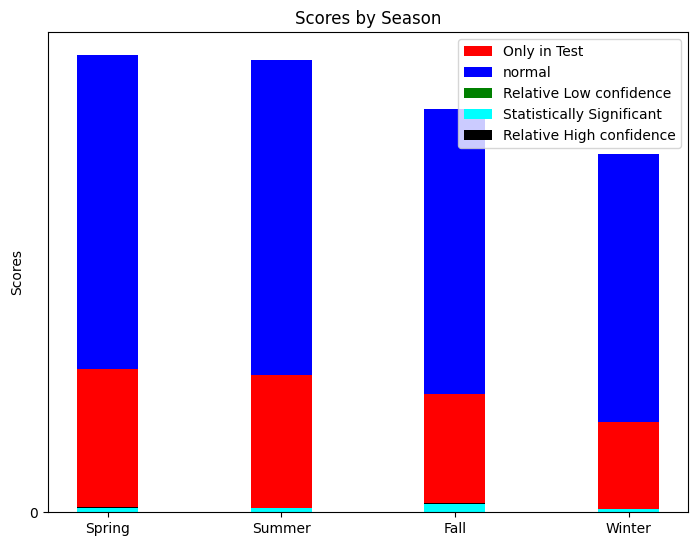

In [86]:


import numpy as np
import matplotlib.pyplot as plt
N = 4
InTestValues = dataFinal[0]
normalValues = dataFinal[1]
SSUnderValues = dataFinal[2]
SSValues = dataFinal[3]
SSOverValues = dataFinal[4]

ind = np.arange(N) # the x locations for the groups
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(ind, InTestValues, width, color='r')
ax.bar(ind, normalValues, width,bottom=InTestValues, color='b') # you need to properly stack them ffs
ax.bar(ind, SSUnderValues, width,bottom=normalValues, color='g')
ax.bar(ind, SSValues, width,bottom=SSUnderValues, color='cyan')
ax.bar(ind, SSOverValues, width,bottom=SSValues, color='black')

ax.set_ylabel('Scores')
ax.set_title('Scores by Season')
ax.set_xticks(ind, ('Spring', 'Summer', 'Fall', 'Winter'))
ax.set_yticks(np.arange(0, 100, 100))
ax.legend(labels=[statusOnlyInTest,'normal',StatisticallySignificantUnderperform,StatisticallySignificant,StatisticallySignificantOverperform])
plt.show()

In [87]:
# for season in range(seasons):
#     classification[season].reset_index(drop=True)
#     classification[season][['Season']] = season
# classification = pd.concat(classification)
# classification

In [88]:
AllRules = rulesTestFold[3][['antecedents','consequents']] 
AllRules

,antecedents,consequents
0,(UHT-milk),(bottled beer)
1,(bottled beer),(UHT-milk)
2,(UHT-milk),(bottled water)
3,(bottled water),(UHT-milk)
4,(newspapers),(UHT-milk)
...,...,...
1353,"(soda, yogurt)",(whole milk)
1354,"(yogurt, whole milk)",(soda)
1355,(soda),"(yogurt, whole milk)"
1356,(whole milk),"(soda, yogurt)"


## Limitations

In the test fold, because we have less data, weobtain more rules than for a bigger dataset, as a particular rule needs less occurrence of its antecedents and consequents in order for the support to be above the threshold.
